## This notebook contains additional models built for project 3 to classify reddit posts between the 'Anxiety' and 'Depression' subreddit

#### Note: These some of these models contain GridSearches that can take 8-10 minutes to run.

These models were built to evaluate the best classification models for presentation

In [1]:
### Import relevant packages / libraries:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('max_columns', 75)
import numpy as np 
import time
import requests
import json
import seaborn as sns
# importing sklearn libraries

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt 

%matplotlib inline
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB

import nltk
from nltk.stem import WordNetLemmatizer

## Reading in the CSV from Data Acquisition Notebook

In [2]:
reddits = pd.read_csv('./reddits.csv')

## EDA and Cleaning:

In [3]:
# there are some rows where the selftext feature has been deleted or remvoed. 
# filtering these out of the dataframe
reddits = reddits[reddits['selftext'] != '[removed]']
reddits = reddits[reddits['selftext'] != '[deleted]']

# the action above removed 187 rows of data
reddits.shape

(3813, 3)

In [4]:
# checking for null_values and found 145 rows
reddits.isnull().sum()
# will fill these with 'blank post'

reddits['selftext'] = reddits['selftext'].fillna('blank post')
#reddits = reddits['selftext'].dropna()

In [5]:
# now there are no nulls
reddits.isnull().sum()

target      0
selftext    0
title       0
dtype: int64

In [6]:
# modifying target column and I will set 'depression' to the positive class (1)
# and 'anxiety' to the negative class (0)
reddits['target'] = reddits['target'].map({'depression':1, 'anxiety':0})

In [7]:
# ensuring that there are no duplicate posts included in our dataframe
reddits.drop_duplicates(keep='first', inplace=True)
# removes 6 duplicate posts
reddits.shape

(3807, 3)

# NLP Processing and Modeling

### Set X and Y Variables

In [8]:
X = reddits['selftext']
y = reddits['target']

## Pipeline & Gridsearch - CountVectorizer and Logistic Regression

In [9]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. LogisticRegression (estimator)

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression(solver = 'liblinear'))
])

pipe_params = {'cvec__max_features': [2000, 3000, 4000],
              'cvec__min_df': [2,3],
              'cvec__max_df': [0.95, 0.98],
              'cvec__ngram_range': [(1,1), (1,2), (1,3)]
}

gs = GridSearchCV(pipe, pipe_params, cv=5)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10025, 
                                                   test_size=0.33,
                                                    stratify=y,)

### Note : cell below takes approximately 520 seconds to run...

In [11]:
import time

# start the timer/

t0= time.time()
gs.fit(X_train, y_train)
print(time.time() - t0) 

614.4821629524231


In [12]:
# identifying the best score from the grid search
gs.best_score_

0.8176470588235294

In [13]:
# creating a model with the best estimator
gs_model = gs.best_estimator_
gs_model

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.95,
                                 max_features=2000, min_df=2,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('logreg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                      

In [14]:
# score on training data set with gs_model
gs_model.score(X_train, y_train)

0.9784313725490196

In [15]:
# score on testing data set with gs_model
gs_model.score(X_test, y_test)

0.8281622911694511

In [16]:
predictions_gs = gs.predict(X_test)

In [17]:
# Building a confusion matrix for the gs_model
pd.DataFrame(confusion_matrix(y_test, predictions_gs), columns=['Prediction: Anxiety', 'Prediction: Depression'],
            index= ['Actual: Anxiety', 'Actual: Depression'])

,Prediction: Anxiety,Prediction: Depression
Actual: Anxiety,546,99
Actual: Depression,117,495


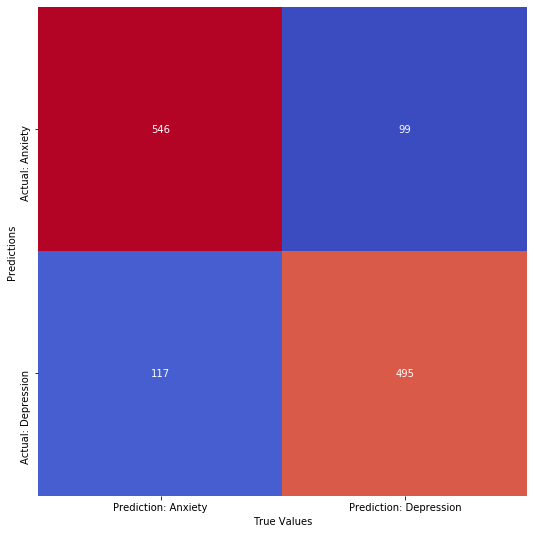

In [18]:
plt.figure(figsize=(16,9))
cm = confusion_matrix(y_test, predictions_gs)
sns.heatmap(cm, square=True, annot=True, cbar=False, fmt='g', cmap='coolwarm',
xticklabels=['Prediction: Anxiety', 'Prediction: Depression'],
            yticklabels=['Actual: Anxiety', 'Actual: Depression'])
plt.xlabel('True Values')
plt.ylabel('Predictions');

### Creating a Naive Bayes Model with CountVectorized Features

In [19]:
# baseline accuracy:
y_test.value_counts(normalize=True)

0    0.513126
1    0.486874
Name: target, dtype: float64

In [20]:
pipe_2 = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

pipe_params_2 = {'cvec__max_features': [2000, 3000], 
                 'cvec__min_df': [2,3], 
                 'cvec__max_df': [0.95, 0.98],
                 'cvec__ngram_range': [(1,1), (1,2), (1,3)], 
                 'mnb__alpha': [0, 0.5, 1]
}

gs_2 = GridSearchCV(pipe, pipe_params, cv=5)

In [21]:
# performing a new train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20005, 
                                                   test_size=0.33,
                                                    stratify=y,)

##### Note: cell below will take approximately 603 seconds to run

In [22]:
# fitting X_train y_train to our new grid 
# and estimating the time it takes to fit
import time

# start the timer/

t0= time.time()
gs_2.fit(X_train, y_train)
print(time.time() - t0) 

603.9098927974701


In [23]:
gs_model_2 = gs_2.best_estimator_
gs_model_2

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.95,
                                 max_features=2000, min_df=2,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('logreg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                      

In [24]:
# score on training data set with gs_model_2
gs_model_2.score(X_train, y_train)

0.9796078431372549

In [25]:
# score on testing data set with gs_model_2
gs_model_2.score(X_test, y_test)

0.8130469371519491

In [26]:
predictions_gs_2 = gs_2.predict(X_test)

In [27]:
# Building a confusion matrix for the gs_model
pd.DataFrame(confusion_matrix(y_test, predictions_gs_2), columns=['Prediction: Anxiety', 'Prediction: Depression'],
            index= ['Actual: Anxiety', 'Actual: Depression'])

,Prediction: Anxiety,Prediction: Depression
Actual: Anxiety,525,120
Actual: Depression,115,497


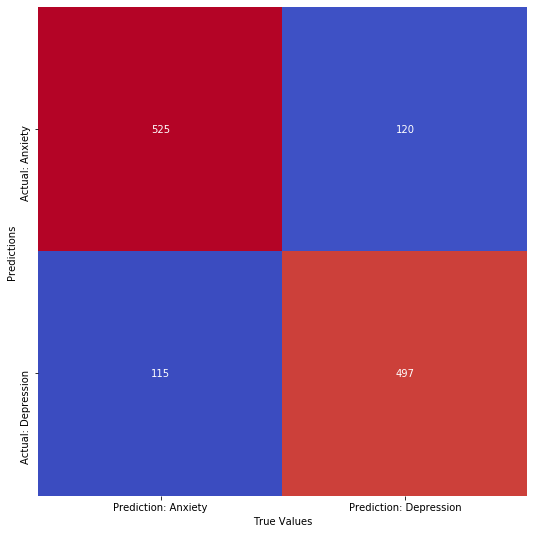

In [28]:
plt.figure(figsize=(16,9))
cm = confusion_matrix(y_test, predictions_gs_2)
sns.heatmap(cm, square=True, annot=True, cbar=False, fmt='g', cmap='coolwarm',
xticklabels=['Prediction: Anxiety', 'Prediction: Depression'],
            yticklabels=['Actual: Anxiety', 'Actual: Depression'])
plt.xlabel('True Values')
plt.ylabel('Predictions');